In [1]:
import math
import datetime

import click
import numpy as np
import torch
import pandas as pd
from environment import Environment
from parameters import Parameters
from src.classes.dataset import Dataset
from src.max_margin_loss import max_margin_loss
from src.model.conv_model import ConvModel
from src.train_loop import train_loop

from src.metrics import get_recommendation_nids, precision_at_k

from logging_config import get_logger

log = get_logger(__name__)
%load_ext autoreload
%autoreload 2

### Préparation des données et du modèle

In [2]:
environment = Environment()
parameters = Parameters({
        'embedding_on_full_set': True
    })


In [9]:
# Create full train set
dataset = Dataset(
    environment, parameters
)

Number of customer in train set :  47767
Number of customer in Valid set :  11942


In [5]:
from src.classes.graphs import Graphs

graphs = Graphs(dataset, parameters)

In [7]:
import dgl
subgraph = dgl.node_subgraph(graphs.history_graph, {
                'article': dataset.articles['article_nid'].values,
                'customer': dataset.customers.iloc[100000:200000]['customer_nid'].values
            })

In [6]:
from src.get_dimension_dictionnary import get_dimension_dictionnary

dim_dict = get_dimension_dictionnary(graphs, parameters)
dim_dict

{'customer': 19, 'article': 600, 'edge': 5, 'out': 96, 'hidden': 192}

In [7]:
from src.classes.dataloaders import DataLoaders

dataloaders = DataLoaders(graphs,
                    dataset,
                    parameters,
                    environment
                    )

Batch size:  1999


In [8]:
model = ConvModel(dim_dict,
                    parameters
                    )

In [9]:
model.load_state_dict(
    torch.load(environment.model_path)
)

<All keys matched successfully>

### Test inference

In [10]:
model.eval()


In [26]:
import dgl 

with torch.no_grad():
    customers_per_graph = 50000
    index = 0

    customer_embeddings_series = []
    article_embeddings_series = []

    while index < len(dataset.customers):
        
        end = min(len(dataset.customers), index + customers_per_graph)
        
        subgraph = dgl.node_subgraph(graphs.history_graph, {
            'article': dataset.articles['article_nid'].values,
            'customer': dataset.customers.loc[index:end - 1, 'customer_nid'].values
        })
        
        embeddings = model.get_embeddings(subgraph, {
                    'article': subgraph.nodes['article'].data['features'],
                    'customer': subgraph.nodes['customer'].data['features'],
                })
        
        customer_embeddings_series.append(embeddings['customer'].detach().float().numpy())
        article_embeddings = embeddings['article'].detach().float().numpy()
        
        print(f"\rProcess subgraph for customers {index} - {end}, length = {len(embeddings['customer'].detach().float().numpy())}", end = "")
        
        index += customers_per_graph

Process subgraph for customers 750000 - 798285, length = 50000

In [27]:
customer_embeddings = np.concatenate(customer_embeddings_series)

In [28]:
dataset.customers['embeddings'] = customer_embeddings

ValueError: Length of values (800000) does not match length of index (798285)

In [25]:
dataset.articles['embeddings'] = article_embeddings

ValueError: Length of values (8293632) does not match length of index (86392)

In [17]:
len(dataset.customers)

798285

In [16]:
dataset.customers['embeddings'] = customer_embeddings

ValueError: Length of values (800016) does not match length of index (798285)

In [10]:
# Get embeddings for all graph.
i = 0
for input_nodes, output_nodes, blocks in dataloaders.dataloader_embedding:
    print(f"\rProcessing batch number {i}", end='')
    
    embeddings = model.get_embeddings(blocks, blocks[0].srcdata['features'])
    
    graphs.history_graph.nodes['article'].data['h'][output_nodes['article'].long()] = embeddings['article'].detach()
    graphs.history_graph.nodes['customer'].data['h'][output_nodes['customer'].long()] = embeddings['customer'].detach()
    
    del embeddings
    
    i += 1
        

Processing batch number 17

In [3]:
import pandas as pd
submission = pd.read_csv("../submission_gnn_first_half.csv")
customers = pd.read_pickle('../pickles/customers.pkl')

In [5]:
submission.dropna(inplace = True)

In [16]:
submissions_1 = customers[['customer_id']].merge(submission, on = "customer_id", how = "left")

In [17]:
submissions_1.fillna('', inplace = True)

In [21]:
submissions_1['prediction'] = submissions_1['prediction'].apply(lambda x: x.replace("['", ""))
submissions_1['prediction'] = submissions_1['prediction'].apply(lambda x: x.replace("']", ""))
submissions_1['prediction'] = submissions_1['prediction'].apply(lambda x: x.replace("', '", " "))

In [22]:
submissions_1

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0868063001 0529195001 0590178001 0631643001 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0868063001 0529195001 0590178001 0631643001 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0868063001 0529195001 0590178001 0631643001 05...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0868063001 0529195001 0590178001 0631643001 05...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0868063001 0529195001 0590178001 0631643001 05...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0868063001 0529195001 0590178001 0631643001 05...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,


In [23]:
submissions_1.to_csv('../submissions/submission_gnn_1.csv', index=None)

In [24]:
graphs.history_graph.nodes['article'].data['h']

tensor([[0.0351, 0.0000, 0.0245,  ..., 0.0000, 0.1807, 0.0994],
        [0.0012, 0.0000, 0.0000,  ..., 0.0000, 0.2963, 0.3339],
        [0.0299, 0.0000, 0.0007,  ..., 0.0000, 0.2412, 0.2106],
        ...,
        [0.0500, 0.0399, 0.0000,  ..., 0.1486, 0.1254, 0.0468],
        [0.0493, 0.0374, 0.0000,  ..., 0.1417, 0.1340, 0.0648],
        [0.0368, 0.0000, 0.0000,  ..., 0.1004, 0.4104, 0.1893]])

In [29]:
pd.read_pickle("../pickles/gnn_article_embeddings.pkl")

,article_id,article_nid,embeddings
0,0871527003,0,"[0.0, 0.0, 0.0, 0.0, 0.09423259645700455, 0.0,..."
1,0922037002,1,"[0.001238139346241951, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,0536139067,2,"[0.0, 0.0, 0.0, 0.0, 0.11435192823410034, 0.0,..."
3,0810557013,3,"[0.0, 0.0, 0.0, 0.0, 0.08439052104949951, 0.0,..."
4,0893432002,4,"[0.0, 0.0, 0.0, 0.0, 0.057343535125255585, 0.0..."
...,...,...,...
104378,0822495007,104378,"[0.05147654563188553, 0.043357573449611664, 0...."
104379,0873109004,104379,"[0.0539916530251503, 0.04097333550453186, 0.0,..."
104380,0883157001,104380,"[0.04995996505022049, 0.03986245393753052, 0.0..."
104381,0880394004,104381,"[0.049288634210824966, 0.0373702235519886, 0.0..."


In [11]:
# Backup embeddings
customer_embeddings = graphs.history_graph.nodes['customer'].data['h'].tolist()



In [12]:
article_embeddings = graphs.history_graph.nodes['article'].data['h'].tolist()

In [13]:
dataset.customers['embeddings'] = customer_embeddings
dataset.articles['embeddings'] = article_embeddings

In [14]:
# Process recommandations
customers_per_batch = 100
current_index = 0
length = graphs.history_graph.num_nodes('customer')

# Backup nid indexes to disk.
customer_index = dataset.customers[['customer_id', 'customer_nid', 'embeddings']]
customer_index.to_pickle('../pickles/gnn_customer_embeddings.pkl')

article_index = dataset.articles[['article_id', 'article_nid', 'embeddings']]
article_index.to_pickle('../pickles/gnn_article_embeddings.pkl')
article_index

,article_id,article_nid,embeddings
0,0933032001,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05656278878450394,..."
1,0664074072,1,"[0.0, 0.0, 0.0, 0.016453295946121216, 0.154051..."
2,0894353002,2,"[0.0, 0.0, 0.0, 0.0, 0.02628682367503643, 0.0,..."
3,0786304009,3,"[0.0, 0.0, 0.0, 0.009951094165444374, 0.157610..."
4,0896169002,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.03771974518895149,..."
...,...,...,...
86387,0644036002,86387,"[0.0, 0.0, 0.0, 0.03564208000898361, 0.2047476..."
86388,0288825024,86388,"[0.0, 0.0, 0.0, 0.03917096182703972, 0.2072441..."
86389,0512568002,86389,"[0.0, 0.0, 0.0, 0.03570757061243057, 0.2048227..."
86390,0869561001,86390,"[0.0, 0.0, 0.0, 0.03285524994134903, 0.1720865..."


In [16]:
customers_per_batch = 50
current_index = 0
length = graphs.history_graph.num_nodes('customer')

recommendation_chunks = []
recommandation_dataframes = []

while current_index < length :
    
    customer_nids = dataset.customers.loc[current_index: current_index + customers_per_batch, 'customer_nid'].values
    
    print(f"\rProcessing train recommendations for customers {current_index} - {current_index + customers_per_batch}            ", end = "")
    new_recommendations = get_recommendation_nids({
        'article': graphs.history_graph.nodes['article'].data['h'].to(environment.device),
        'customer': graphs.history_graph.nodes['customer'].data['h'][customer_nids].to(environment.device),
    }, parameters, environment, cutoff = max(parameters.precision_cutoffs), model = model)
    
    
    recommendation_chunks.append(
        np.concatenate([customer_nids.reshape((-1, 1)), new_recommendations], axis = 1)
    )

    # Backup chunks every 100 000 users.
    if (current_index != 0 and current_index % 50000 == 0) or current_index + customers_per_batch > len(dataset.customers):
        print("Backup recommandations for customers {}")
        dataframe = pd.DataFrame(np.concatenate(recommendation_chunks))
        
        recommendation_chunks = []
        
        recommandation_dataframes.append(dataframe)
        dataframe.to_pickle(f"../pickles/gnn_recommandations_{len(recommandation_dataframes)}.pkl")
    
    current_index += customers_per_batch

Processing train recommendations for customers 50000 - 50050            Backup recommandations for customers {}
Processing train recommendations for customers 55800 - 55850            

KeyboardInterrupt: 

In [34]:
    # Prepare dataframes.
    print("Concatenate and prepare dataframes.")
    recommandations = pd.concat(recommandation_dataframes)

Concatenate and prepare dataframes.


51051

In [24]:

# Add real customers ID.
recommandations = recommandations.merge(customer_index[['customer_id', 'customer_nid']], left_on = 0, right_on = "customer_nid", how = "left")

# Add real articles IDs
for i in range(12):
    recommandations = recommandations.merge(article_index[['article_id', 'article_nid']], left_on = i+1, right_on = "article_nid", how = "left")
    recommandations.rename({f"article_id": f"article_{i}"}, axis = 1, inplace = True)
    
# Remove unused columns
recommandations.drop(columns = ['article_nid_x', 'article_nid_y'], axis = 1, inplace = True)
recommandations.drop(columns = [i for i in range(13)], axis = 1, inplace = True)

# Save expanded recommandation list.
recommandations.to_pickle("../pickles/gnn_recommandations_expanded.pkl")

# Save compiled submission.

recommandations['prediction'] = recommandations.apply(lambda x: [x[f"article_{i}"] for i in range (12)], axis = 1)

submission = pd.read_pickle(environment.customers_path)
submission = submission[['customer_id']]
submission = submission.merge(
    recommandations[['customer_id', 'prediction']], how='left', on='customer_id')


In [27]:
recommandations.drop(columns = ['article_nid_x', 'article_nid_y'], axis = 1)

,customer_id,customer_nid,article_0,article_1,article_2,article_3,article_4,article_5,article_6,article_7,article_8,article_9,article_10,article_11,prediction
0,4fa98e99f29b6088b619b2105704352cf76e4c479baf4c...,0,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
1,a7b0729b1571599d796d79d9caf49d203f37d19b1c4efa...,1,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
2,65d6202fb0aebd94de3fcaf31602fc3c32cdf50be9fd51...,2,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0923534001,0926745001,0810172018,0891763001,0719530014,0895836001,"[0881570005, 0903861003, 0926825001, 092432000..."
3,d3670e922c6226413c285a378aa4f9f633c127d2bea39b...,3,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
4,3cade6fa9c62dff55c47b59b6812ced2be0dece54ccb21...,4,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0891763001,0748355018,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51046,7b6336e3639ce502ecba83ed05139b0de2c4cf7835fdff...,50046,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
51047,c96b4f794bf6105f7b322be47fdfe808302ce3af8fb784...,50047,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
51048,beda2375c2ba005d4b2ec3fd9ae13db1b16c06682069a0...,50048,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."
51049,8ae39d7537604891f23c7e19ca631593f4784549044fc3...,50049,0881570005,0903861003,0926825001,0924320002,0865938001,0807241060,0926745001,0895836001,0748355018,0891763001,0923534001,0810172018,"[0881570005, 0903861003, 0926825001, 092432000..."


In [32]:
submission.dropna()

,customer_id,prediction
38,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"[0881570005, 0903861003, 0926825001, 092432000..."
147,000608ab13228c9d4f90f2e7e7dfd3b0c280d84ae817bf...,"[0881570005, 0903861003, 0926825001, 092432000..."
176,0007666ed01a41da49ce4991a713fd5848f3bf10e40dda...,"[0881570005, 0903861003, 0926825001, 092432000..."
179,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0881570005, 0903861003, 0926825001, 092432000..."
214,0008f331af4a75fa03b97fc9ae41cf8342f7f6dc648ae5...,"[0881570005, 0903861003, 0926825001, 092432000..."
...,...,...
1372846,fff93419c3fda6c71f53628aab6d97c9429ae4f9e61933...,"[0881570005, 0903861003, 0926825001, 092432000..."
1372848,fff9495534edbb084062ded1c747da98acdfc855632ae1...,"[0881570005, 0903861003, 0926825001, 092432000..."
1372867,fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82b...,"[0881570005, 0903861003, 0926825001, 092432000..."
1372868,fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82b...,"[0881570005, 0903861003, 0926825001, 092432000..."


In [8]:

opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)
#embeddings = model.get_embeddings(graphs.history_graph, {
#                'article': graphs.history_graph.nodes['article'].data['features'],
#                'customer': graphs.history_graph.nodes['customer'].data['features'],
#            })
#
model.train()

opt.zero_grad()

In [32]:
graphs.full_graph.nodes['article'].data['h'] = torch.rand(48982, 128)
graphs.full_graph.nodes['customer'].data['h'] = torch.rand(30251, 128)

In [33]:
for inputs, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    break


In [47]:
np.array([True, False, True]).min()

False

In [ ]:
model.get_embeddings(blocks, blocks[0].srcdata['features'])

In [ ]:
trained_model, viz, best_metrics = train_loop(
    model=model,
    graphs=graphs,
    dataset=dataset,
    dataloaders=dataloaders,
    loss_fn=max_margin_loss,
    get_metrics=True,
    parameters=parameters,
    environment=environment,
)

### Test de la boucle de recommandation

In [4]:
environment = Environment()
environment.transactions_path = "../pickles/transactions_sampled.pkl"
parameters = Parameters({})

dataset = Dataset(environment, parameters)


Number of customer in train set :  10162
Number of customer in Valid set :  2540


In [5]:
# Préparation d'un dataset avec des vecteurs
predictions = dataset.purchased_list.copy()
predictions[predictions['length'] > 1]

,customer_nid,articles,length
6,6,"[1272, 466]",2
13,13,"[4961, 5126]",2
16,16,"[2684, 1267, 5792]",3
18,18,"[737, 161, 4706, 850]",4
28,28,"[715, 3877]",2
...,...,...,...
12667,12667,"[1809, 5281]",2
12668,12668,"[377, 976, 46]",3
12672,12672,"[201, 1692, 31, 1595]",4
12674,12674,"[1407, 1608]",2


In [6]:
# Vérifie que les nid des articles sont bien contigües
nb_articles = dataset.articles_in_prediction_nid.shape[0]
assert (dataset.articles_in_prediction_nid == np.arange(0, nb_articles)).min() == True

In [15]:
### Création de vecteurs de score vide pour chacun des clients

def full_score_tensor(x):
    tensor = torch.zeros(nb_articles)
    for i in x['articles']:
        tensor[i] = 0.5
        
    return tensor.reshape(1, nb_articles)

def full_minus(x, amount = 1):
    tensor = full_score_tensor(x)
    
    for i in range(amount):
        false_index = np.random.randint(0, nb_articles)
        tensor[0, false_index] = 1

    return tensor

def only_one(x):
    tensor = torch.zeros(nb_articles)
    tensor[x['articles'][0]] = 0.5
        
    return tensor.reshape(1, nb_articles)

# Aléatoire
predictions['random'] = predictions.apply(lambda x: torch.rand(nb_articles).reshape(1, nb_articles), axis = 1)

# Score de 1
predictions['full'] = predictions.apply(lambda x: full_score_tensor(x), axis = 1)
predictions['full_minus_one'] = predictions.apply(lambda x: full_minus(x, 1), axis = 1)
predictions['full_minus_three'] = predictions.apply(lambda x: full_minus(x, 3), axis = 1)
predictions['only_one'] = predictions.apply(lambda x: only_one(x), axis = 1)


# Créer les tenseurs.
random = torch.cat(predictions['random'].values.tolist())
full =  torch.cat(predictions['full'].values.tolist())
full_minus_one = torch.cat(predictions['full_minus_one'].values.tolist())
full_minus_three = torch.cat(predictions['full_minus_three'].values.tolist())
only_one = torch.cat(predictions['only_one'].values.tolist())

predictions

,customer_nid,articles,length,random,full,full_minus_one,only_one,full_minus_three
0,0,[1779],1,"[[tensor(0.9904), tensor(0.5876), tensor(0.822...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
1,1,[1372],1,"[[tensor(0.3547), tensor(0.1808), tensor(0.914...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2,2,[1165],1,"[[tensor(0.1837), tensor(0.0252), tensor(0.400...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
3,3,[48],1,"[[tensor(0.9988), tensor(0.3723), tensor(0.713...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
4,4,[920],1,"[[tensor(0.8381), tensor(0.4164), tensor(0.183...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
...,...,...,...,...,...,...,...,...
12697,12697,[4952],1,"[[tensor(0.5901), tensor(0.1910), tensor(0.699...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12698,12698,[1624],1,"[[tensor(0.7226), tensor(0.9217), tensor(0.285...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12699,12699,[3575],1,"[[tensor(0.6441), tensor(0.3522), tensor(0.883...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12700,12700,[405],1,"[[tensor(0.9409), tensor(0.0816), tensor(0.068...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


In [18]:
predictions.length.value_counts()

1     10301
2      1859
3       397
4       101
5        28
6        11
7         4
11        1
Name: length, dtype: int64

In [8]:
def score(predictions, customer_nids, cutoff):
    
    recommendations = torch.argsort(predictions, dim=1, descending=True)[customer_nids, 0:cutoff]
    
    return recommendations

In [21]:
# Test des fontions seules
customer_nids = predictions['customer_nid'].unique()
recommendations = score(full_minus_three, customer_nids, 3)

precision = precision_at_k(full, customer_nids, dataset, parameters)
recommendations

tensor([[1129, 4141, 1694],
        [4803, 2283, 5807],
        [3990, 1212, 5071],
        ...,
        [5494,  511, 5147],
        [3462, 2569, 1103],
        [  97,  681, 5476]])

In [41]:
y = {
    'customer': torch.tensor([[1, 1, 1, 1, 1]]).float(),
    'article': torch.tensor([[5, 4, 3, 2, 1]]).float()
}


        
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

cos(
    y['customer'].reshape(-1, 2, 1),
    torch.transpose(y['article'], 0, 1).reshape(1, 2, -1)
)


tensor([[0.7071]])

In [26]:
# Reproduce loop
def get_metrics(pred_list, dataset, all_customer_nids, parameters, customers_per_batch = 200):
    current_index = 0
    length = len(all_customer_nids)

    recommendation_chunks = []
    customer_nids_chunks = []
    precision_list = np.array([])

    while current_index < length :
        
        batch_customer_nids = all_customer_nids[current_index: current_index + customers_per_batch]

        print(f"\rProcessing valid recommendations for customers {current_index} - {current_index + customers_per_batch}                     ", end = "")
        new_recommendations = score(pred_list, batch_customer_nids, cutoff = max(parameters.precision_cutoffs))
        
        recommendation_chunks.append(new_recommendations)
        customer_nids_chunks.append(batch_customer_nids)

        # Calculate precision when the number of chunks is considered as optimal.
        if current_index % 5000 == 0 or current_index + customers_per_batch > length:
            
            recommendations = np.concatenate(recommendation_chunks, axis = 0)
            batch_customer_nids = np.concatenate(customer_nids_chunks, axis = 0)
            
            precision = precision_at_k(recommendations, batch_customer_nids, dataset, parameters)
            
            if precision_list.shape[0] == 0:
                precision_list = np.array([precision])
            else: 
                precision_list = np.append(precision_list, [precision], axis = 0)
            
            recommendation_chunks = []
            customer_nids_chunks = []
        
        current_index += customers_per_batch
        
    return np.mean(precision_list, axis = 0)

In [31]:
get_metrics(random, dataset, dataset.customers_nid_train, parameters)

Processing valid recommendations for customers 10000 - 20000                     

array([0.00026667, 0.00071667, 0.00124167])

In [1]:
opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)


NameError: name 'parameters' is not defined

In [46]:
embeddings = model.get_embeddings(graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

graphs.prediction_graph.nodes['article'].data['h'] = embeddings['article'][0:graphs.prediction_graph.num_nodes('article')]
graphs.prediction_graph.nodes['customer'].data['h'] = embeddings['customer'][0:graphs.prediction_graph.num_nodes('customer')]


In [10]:
torch.autograd.set_detect_anomaly(True)

In [13]:
for _, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    break


pos_score, neg_score = model(pos_g, neg_g, graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

                                
pos_score = torch.nan_to_num(pos_score, 0)
neg_score = torch.nan_to_num(neg_score, 0)

loss = max_margin_loss(pos_score,
                neg_score,
                parameters=parameters,
                environment=environment
                )

loss.backward()
opt.step()
                    

Embeddings:  tensor([[0.0000, 0.0000, 0.0382,  ..., 0.0000, 0.0061, 0.0831],
        [0.0000, 0.0833, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0164, 0.0000, 0.0855,  ..., 0.0000, 0.0138, 0.1343],
        ...,
        [0.0000, 0.1210, 0.0000,  ..., 0.0711, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0666,  ..., 0.0253, 0.0000, 0.0834],
        [0.0000, 0.0000, 0.0502,  ..., 0.0000, 0.0074, 0.0970]],
       grad_fn=<SliceBackward0>)


In [9]:
model.train_loss_list = []
model.train_precision_list = []
model.train_recall_list = []
model.train_coverage_list = []
model.val_loss_list = []
model.val_precision_list = []
model.val_recall_list = []
model.val_coverage_list = []
best_metrics = {}  # For visualization
max_metric = -0.1
patience_counter = 0  # For early stopping
min_loss = 1.1

opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)


### Entraînement (1 itération)

In [10]:
model.predict.to(environment.device)

CosinePrediction()

In [18]:
model.train()
opt.zero_grad()

embeddings = model(graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

In [19]:
graphs.prediction_graph.nodes['article'].data['h'] = embeddings['article'][0:graphs.prediction_graph.num_nodes('article')]
graphs.prediction_graph.nodes['customer'].data['h'] = embeddings['customer'][0:graphs.prediction_graph.num_nodes('customer')]

In [20]:
pos_score = torch.tensor([]).to(environment.device)
neg_score = torch.tensor([]).to(environment.device)

In [42]:
model.predict.to(environment.device)

CosinePrediction()

In [23]:
for _, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    print(blocks)
    break
    pos_g.to(environment.device)
    neg_g.to(environment.device)
    #
    pos_score = torch.cat([pos_score, model.predict(pos_g).to(environment.device)], dim = 0)
    #
    neg_g.nodes['article'].data['h'] = graphs.history_graph.nodes['article'].data['h'][neg_g.nodes['article'].data['_ID'].long()]
    neg_g.nodes['customer'].data['h'] = graphs.history_graph.nodes['customer'].data['h'][neg_g.nodes['customer'].data['_ID'].long()]
    #
    neg_score = torch.cat([neg_score, model.predict(neg_g).to(environment.device)], dim = 0)
    break


[Block(num_src_nodes={'article': 2937, 'customer': 3691},
      num_dst_nodes={'article': 2937, 'customer': 3691},
      num_edges={('customer', 'buys', 'article'): 0},
      metagraph=[('customer', 'article', 'buys')])]


In [44]:
pos_score = torch.nan_to_num(pos_score, 0)
neg_score = torch.nan_to_num(neg_score, 0)

In [45]:
loss = max_margin_loss(pos_score,
                           neg_score,
                           parameters=parameters,
                           environment=environment
                           )


In [46]:
loss.backward()
opt.step()

### Métrique

In [72]:
customers_per_batch = 200
current_index = 0
length = graphs.prediction_graph.num_nodes('customer')

precision_list = np.array([])
recommendation_chunks = []

while current_index < length :
    
    print(f"\rProcessing recommendations for customers {current_index} - {current_index + customers_per_batch}", end = "")
    new_recommendations = get_recommendation_tensor({
        'article': graphs.prediction_graph.nodes['article'].data['h'].to(environment.device),
        'customer': graphs.prediction_graph.nodes['customer'].data['h'][current_index: current_index + customers_per_batch].to(environment.device),
    }, parameters, environment)
    
    recommendation_chunks.append(new_recommendations)

    customer_nids = range(current_index, current_index + customers_per_batch)


    if current_index % 5000 == 0:
        recommendations = torch.cat(recommendation_chunks, dim = 0)
        
        precision = precision_at_k(recommendations, customer_nids, dataset)
        precision_list = np.append(precision_list, precision)
        
        recommendation_chunks = []
    
    current_index += customers_per_batch
    
precision = np.mean(precision_list)


Processing recommendations for customers 25400 - 25600

KeyboardInterrupt: 

### Compilation des recommandations

In [4]:
parameters.embedding_on_full_set = True

In [5]:
dataset = Dataset(environment, parameters)

In [7]:
from src.classes.graphs import Graphs

graphs = Graphs(dataset)

In [15]:
from src.classes.dataloaders import DataLoaders

dataloaders = DataLoaders(graphs,
                    dataset,
                    parameters,
                    environment
                    )

In [31]:
for input_nodes, output_nodes, blocks in dataloaders.dataloader_embedding:
    embeddings = model.forward(blocks, blocks[0].srcdata['features'])
    
    if 'customer' in output_nodes.keys():
        graphs.history_graph.nodes['customer'].data['h'][output_nodes['customer'].long()] = embeddings['customer']
    
    if 'article' in output_nodes.keys():
        graphs.history_graph.nodes['article'].data['h'][output_nodes['article'].long()] = embeddings['article']
        
    break

layer 0
torch.Size([1000, 256])
torch.Size([3195, 256])
layer 1
torch.Size([1000, 256])
torch.Size([0, 256])
layer 2
torch.Size([1000, 256])
torch.Size([0, 256])
layer 3
torch.Size([1000, 128])
torch.Size([0, 128])


### Interprétation des hyperparamètres

In [3]:
import pandas as pd
search_table = pd.read_pickle("../pickles/search_result_table_first_pass_with_loss.pkl")

In [4]:
search_table.drop(columns = ['precision', 'neighbor_sampling', 'out_dim', 'hidden_dim'], inplace = True, axis = 1)

In [3]:
import pandas as pd
search_table = pd.read_pickle("../pickles/search_result_table.pkl")
search_table.tail(20)

search_table.drop(columns=['out_dim', 'hidden_dim', 'neighbor_sampling'], axis = 1, inplace = True)
search_table.sort_values('precision', ascending=False).head(20)

,aggregator_hetero,aggregator_type,aggregator_weighted,delta,dropout,embed_dim,embedding_layer,lr,n_layers,neg_sample_size,norm,reduce_article_features,lost_patience,min_loss,precision
0,max,pool_nn_weighted,True,0.170380,0.214797,Large,True,0.000360,2,2194,True,True,True,0.102422,0.031205
0,max,pool_nn,False,0.198930,0.234061,Small,True,0.000127,2,1840,True,False,True,0.149923,0.030357
0,mean,pool_nn,False,0.330916,0.231267,Small,True,0.000460,3,1025,False,False,True,0.224554,0.029016
0,sum,pool_nn,False,0.163194,0.107120,Very Small,True,0.000128,2,2338,True,False,False,0.120248,0.028920
0,mean,pool_nn_weighted,True,0.150000,0.100000,Medium,True,0.000100,2,2353,True,False,False,0.095098,0.028850
0,max,pool_nn,False,0.238132,0.147608,Very Small,True,0.000985,4,1396,False,False,True,0.160739,0.028104
0,max,pool_nn,False,0.220728,0.254943,Small,True,0.000996,2,1226,True,False,True,0.138689,0.027687
0,mean,mean_nn,False,0.157330,0.310368,Medium,True,0.000779,2,2409,False,False,True,0.090618,0.027299
0,mean,pool_nn,False,0.266820,0.102780,Very Small,True,0.000102,2,1092,True,True,False,0.206194,0.026988
0,mean,mean_nn_weighted,True,0.178444,0.297422,Very Large,False,0.000248,2,1684,True,False,False,0.123258,0.026684


In [8]:
search_table[(search_table['n_layers'] == 3) & (search_table['embed_dim'] == 'Medium')].sort_values('precision', ascending=False).head(10)

,aggregator_hetero,aggregator_type,aggregator_weighted,delta,dropout,embed_dim,embedding_layer,lr,n_layers,neg_sample_size,norm,reduce_article_features,lost_patience,min_loss,precision
0,sum,pool_nn,False,0.300906,0.210711,Medium,True,0.000986,3,1937,False,True,True,0.195192,0.025882
0,mean,pool_nn_weighted,True,0.154860,0.310285,Medium,True,0.000238,3,1474,True,True,True,0.105623,0.025714
0,max,pool_nn_weighted,True,0.220209,0.422786,Medium,True,0.000100,3,1730,True,True,True,0.165773,0.024918
0,mean,pool_nn,False,0.150000,0.164633,Medium,True,0.001000,3,2133,True,False,True,0.098792,0.024293
0,max,pool_nn_weighted,True,0.260139,0.271730,Medium,True,0.000100,3,2018,True,True,True,0.189876,0.024134
0,max,pool_nn_weighted,True,0.289182,0.798773,Medium,True,0.000396,3,1070,True,True,True,0.231378,0.023615
0,sum,pool_nn,False,0.350000,0.139954,Medium,True,0.000485,3,948,True,True,True,0.220688,0.023358
0,sum,pool_nn_weighted,True,0.265812,0.632882,Medium,True,0.001000,3,2295,True,True,True,0.203042,0.022404
0,max,pool_nn_weighted,True,0.300000,0.200000,Medium,True,0.000150,3,1250,True,False,True,0.233564,0.020948
0,mean,mean,False,0.150000,0.264627,Medium,True,0.000165,3,2364,True,False,False,0.102929,0.020873


In [5]:
search_table.to_pickle("../pickles/search_result_table_backup.pkl")

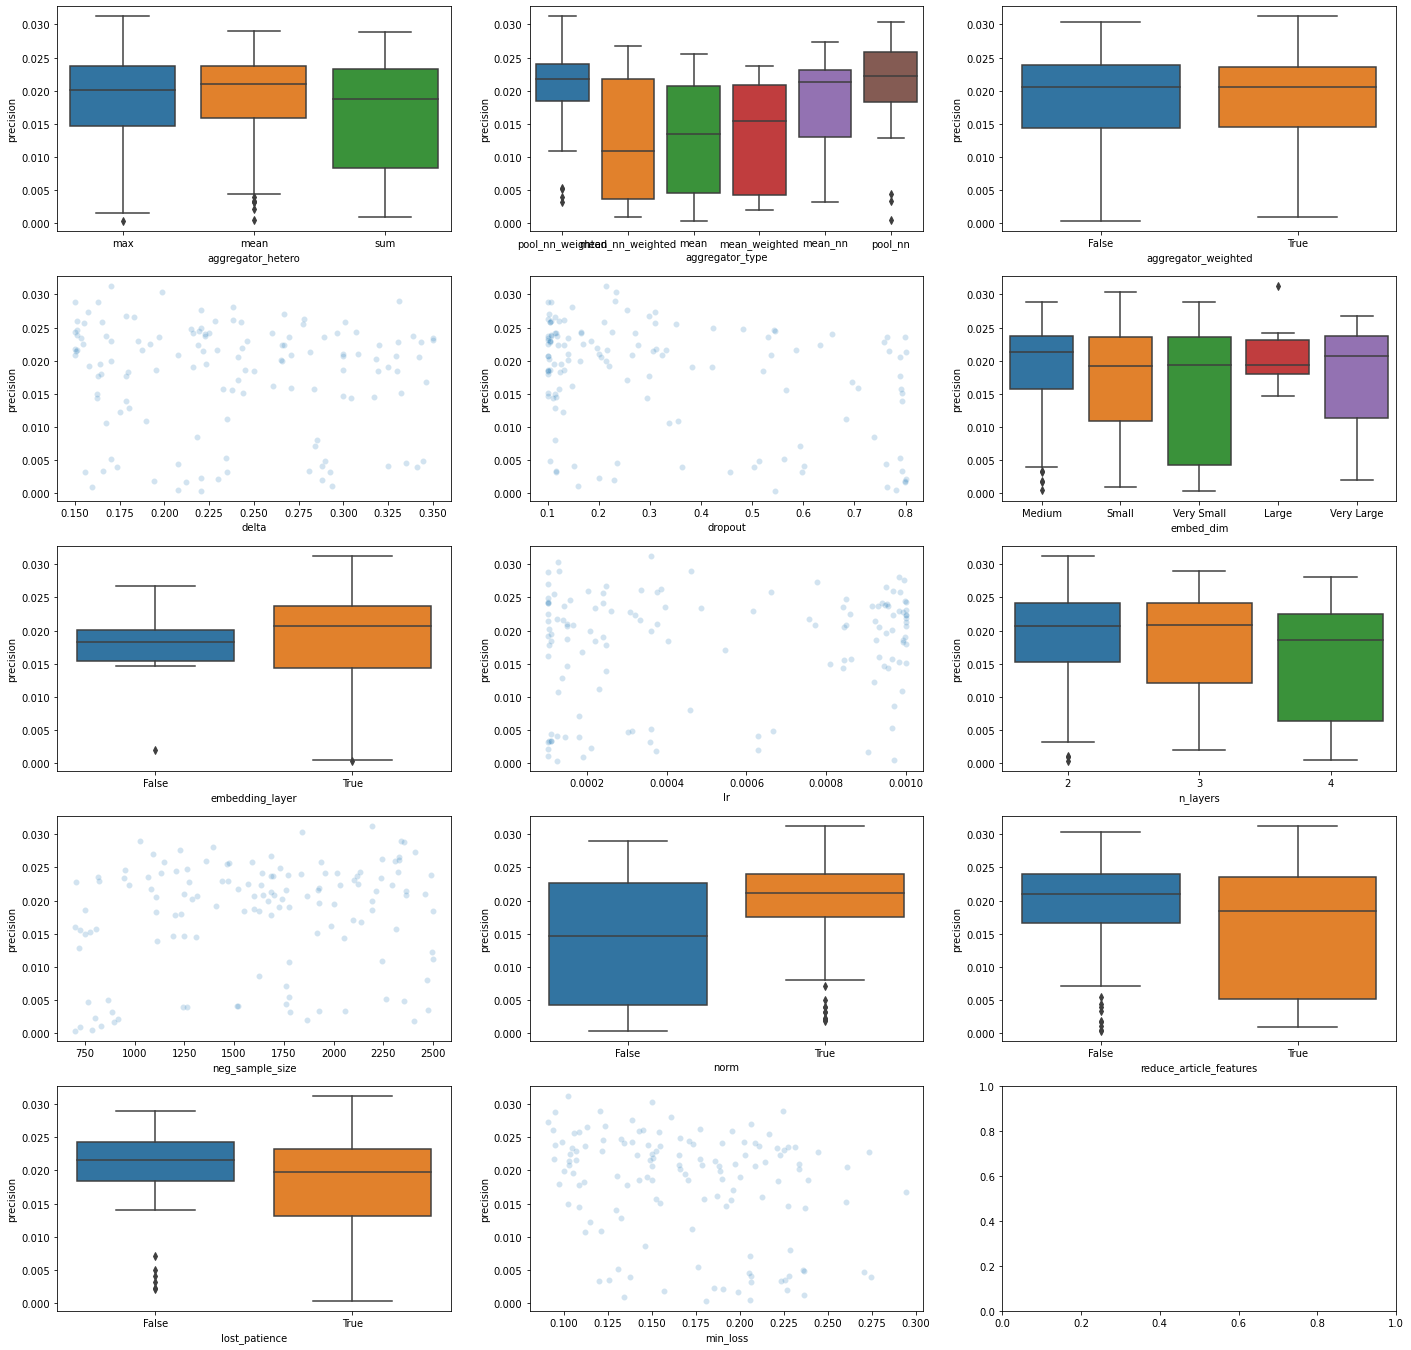

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

search_table_filtered = search_table

non_numeric = ['aggregator_hetero', 'aggregator_type', 'aggregator_weighted', 'embed_dim', 'embedding_layer', 'reduce_article_features', 'n_layers',
       'norm', 'out_dim', 'hidden_dim', 'precision', 'lost_patience']

fig, axes = plt.subplots(5, 3, figsize=(24, 24))

for i in range(len(search_table_filtered.columns) - 1):
       column = search_table_filtered.columns[i]
       if column in non_numeric:
              sns.boxplot(ax = axes[i // 3][i % 3], x = search_table_filtered.columns[i], y = 'precision',  data = search_table_filtered)
       else :
              sns.scatterplot(ax = axes[i // 3][i % 3], x = search_table_filtered.columns[i], y = 'precision', alpha = 0.2, data = search_table_filtered)
              
plt.show()

### Analyse de la prédiction

In [11]:
import pandas as pd
raw_prediction = pd.read_pickle('../pickles/gnn_recommandations_raw.pkl')
raw_prediction

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,100,1635,386,184,329,1096,2501,333,1342,9,56,303
1,1,100,1635,386,184,329,1096,2501,333,1342,56,303,193
2,2,100,1635,386,184,329,1096,2501,333,1342,56,193,303
3,3,100,1635,386,184,329,1096,2501,333,1342,303,56,193
4,4,100,1635,386,184,329,1096,2501,333,1342,303,56,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59370,59370,100,1635,386,184,329,1096,2501,333,1342,56,193,303
59371,59371,100,1635,386,184,329,1096,2501,333,1342,56,193,303
59372,59372,100,1635,386,184,329,1096,2501,333,1342,56,303,193
59373,59373,100,1635,386,184,329,1096,2501,333,1342,56,193,307


In [14]:
purchase_list = pd.read_pickle('../pickles/gnn_purchase_list.pkl')
purchase_list

,customer_nid,articles,length
0,0,"[0, 382, 386, 619, 700, 840]",6
1,1,"[1, 12, 122, 1379, 1388]",5
2,2,"[2, 75]",2
3,3,[3],1
4,4,"[4, 13, 3002, 4366]",4
...,...,...,...
59370,59370,[8045],1
59371,59371,"[2152, 7786]",2
59372,59372,"[942, 1066, 2566]",3
59373,59373,"[2009, 2009, 5552, 6470, 15387]",5


In [12]:
raw_prediction['prediction'] = raw_prediction.apply(lambda x: list([x[i + 1] for i in range (12)]), axis = 1)
raw_prediction

,0,1,2,3,4,5,6,7,8,9,10,11,12,prediction
0,0,100,1635,386,184,329,1096,2501,333,1342,9,56,303,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
1,1,100,1635,386,184,329,1096,2501,333,1342,56,303,193,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
2,2,100,1635,386,184,329,1096,2501,333,1342,56,193,303,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
3,3,100,1635,386,184,329,1096,2501,333,1342,303,56,193,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
4,4,100,1635,386,184,329,1096,2501,333,1342,303,56,193,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59370,59370,100,1635,386,184,329,1096,2501,333,1342,56,193,303,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
59371,59371,100,1635,386,184,329,1096,2501,333,1342,56,193,303,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
59372,59372,100,1635,386,184,329,1096,2501,333,1342,56,303,193,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."
59373,59373,100,1635,386,184,329,1096,2501,333,1342,56,193,307,"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13..."


In [15]:
score_table = purchase_list.merge(raw_prediction, left_on = 'customer_nid', right_on = 0, how = 'left' )[['customer_nid', 'articles' ,'prediction']]
score_table['length'] = score_table['articles'].apply(lambda x: len(x))
score_table['prediction_length'] = score_table['prediction'].apply(lambda x: len(x))
score_table

,customer_nid,articles,prediction,length,prediction_length
0,0,"[0, 382, 386, 619, 700, 840]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",6,12
1,1,"[1, 12, 122, 1379, 1388]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",5,12
2,2,"[2, 75]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",2,12
3,3,[3],"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",1,12
4,4,"[4, 13, 3002, 4366]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",4,12
...,...,...,...,...,...
59370,59370,[8045],"[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",1,12
59371,59371,"[2152, 7786]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",2,12
59372,59372,"[942, 1066, 2566]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",3,12
59373,59373,"[2009, 2009, 5552, 6470, 15387]","[100, 1635, 386, 184, 329, 1096, 2501, 333, 13...",5,12


In [16]:
score_table['precision_at_12'] = score_table.apply(
    lambda x: np.sum(
                np.where(
                    x['prediction'][i] in x['articles'],
                    1,
                    0
                ) for i in range(min(12, x['prediction_length']))
            ) / min(12, x['length'], x['prediction_length']),
    axis=1)

/tmp/ipykernel_7897/496177111.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  lambda x: np.sum(


In [56]:
submission = pd.read_pickle('../pickles/gnn_recommandations_expanded.pkl')
submission

,customer_id,customer_nid,article_0,article_1,article_2,article_3,article_4,article_5,article_6,article_7,article_8,article_9,article_10,article_11
0,7853fcaaad1e91c729ae9f4f31882f413ee9618cbe3077...,0,0904571001,0914449001,0762846027,0923758001,0863646001,0809238005,0873279003,0924243001,0923576001,0911870001,0865799006,0918522001
1,1c68ff81ce18c176f6d5133da4e706308cb0297d6e6648...,1,0904571001,0914449001,0762846027,0923758001,0863646001,0809238005,0873279003,0924243001,0923576001,0865799006,0918522001,0924243002
2,36823912d53c2116d564fc0ea05a086b419eda1b1fcbab...,2,0904571001,0914449001,0762846027,0923758001,0863646001,0809238005,0873279003,0924243001,0923576001,0865799006,0924243002,0918522001
3,0c62dfa1f9913e2f0b761c95fa9adf00524523314983ab...,3,0904571001,0914449001,0762846027,0923758001,0863646001,0809238005,0873279003,0924243001,0923576001,0918522001,0865799006,0924243002
4,4d82a3ebf1d3810af5b23f6719f9118f28d8d439b15c0d...,4,0904571001,0914449001,0762846027,0923758001,0863646001,0809238005,0873279003,0924243001,0923576001,0918522001,0865799006,0924243002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001376,b09ff3fedb9964f86382cc3db026c982440252277d185a...,1001376,0707135017,0762846031,0902265001,0610776068,0719655014,0678942054,0893059004,0707135013,0568601043,0751471001,0915529003,0700701002
1001377,56647a8b053913694845e7dc10b593e2c240c6d10ac064...,1001377,0762846031,0707135017,0902265001,0700701002,0610776068,0719655014,0759814010,0868874006,0852584001,0678942054,0706016015,0893059004
1001378,560291fa595063531d9717a218c0d2f317d299e67ee108...,1001378,0707135017,0902265001,0762846031,0893059004,0610776068,0678942054,0707135013,0918726001,0874754002,0719655014,0868874006,0915529003
1001379,bc9e80410762a5d31514426174fd2ad63fcd25028ae539...,1001379,0707135017,0762846031,0902265001,0610776068,0719655014,0678942054,0568601043,0707135013,0893059004,0751471001,0700701002,0915529003


In [67]:
submission['prediction'] = submission.apply(lambda x: list([x[f"article_{i}"] for i in range(11, -1, -1)]), axis = 1)

In [58]:
import numpy as np

def map12_from_series(purchased_articles, prediction):
    """Process the map12 score from the purchased articles and a prediction.

    Args:
        purchased_articles (pd.Series): the list of purchased articles for each customer
        prediction (pd.Series): the prediction (list format) for each customer.

    Returns:
        A pd.Series object containing the score for each customer.
    """

    return pd.concat([purchased_articles.rename('purchased_articles'), prediction.rename('prediction')], axis=1).apply(
        lambda x: np.sum(
            np.fromiter(
                (np.where(
                    x.prediction[cutoff] in x.purchased_articles,
                    np.sum(
                        np.fromiter(
                            (np.where(
                                x.prediction[position] in x.purchased_articles,
                                1 / (cutoff + 1),
                                0
                            ) for position in range(0, cutoff + 1)),
                            float
                        )
                    ),
                    0
                ) for cutoff in range(0, min(len(x.prediction), 12))),
                float)
        ) / min(len(x.purchased_articles), 12),
        axis=1)

In [59]:
transactions = pd.read_pickle('../pickles/transactions_without_outliers.pkl')
transactions = transactions[transactions['week_number'] == 0]

In [68]:
score_table = transactions.groupby('customer_id', as_index = False).agg(
    purchase_list = ('article_id', lambda x: list(x))
)
score_table = score_table.merge(submission[['customer_id', 'prediction']], on = 'customer_id', how = 'left')
score_table['prediction'] = score_table['prediction'].fillna('').apply(lambda x: list(x))


In [69]:
score_table['prediction_length'] = score_table['prediction'].apply(lambda x: len(x))
score_table = score_table[score_table['prediction_length'] != 0]

In [62]:
score_table.apply(
    lambda x: np.sum(
                np.where(
                    x['prediction'][i] in x['purchase_list'],
                    1,
                    0
                ) for i in range(min(1, len(x['prediction'])))
            ) / min(1, len(x['purchase_list']), len(x['prediction'])),
    axis=1).mean()

/tmp/ipykernel_7897/3227752483.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  lambda x: np.sum(


0.0033144798245469385

In [73]:
for i in range(12):
    score_table[f'score_{i}'] = score_table.apply(
        lambda x: 1 if x['prediction'][i] in x['purchase_list'] else 0,
        axis = 1
    )
score_table.describe()

,prediction_length,score,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,score_11
count,60643.0,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000,60643.000000
mean,12.0,0.007046,0.007239,0.007552,0.005771,0.000890,0.011048,0.002556,0.002012,0.004601,0.007486,0.005656,0.002836,0.003314
std,0.0,0.053050,0.084775,0.086576,0.075751,0.029827,0.104529,0.050492,0.044808,0.067673,0.086200,0.074994,0.053182,0.057477
min,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
score_table['score'] = map12_from_series(score_table['purchase_list'], score_table['prediction'])

In [71]:
score_table['score'].mean()

0.007046234828156585

In [74]:
score_table[['customer_id', 'purchase_list', 'prediction']].to_pickle('../pickles/gnn_score.pkl')

In [33]:
raw = pd.read_pickle('../pickles/gnn_recommandations_expanded_second_half.pkl')


In [81]:
submission = pd.read_csv('../submissions/submission_gnn.csv')
submission['prediction'] = submission['prediction'].fillna('')
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0910449002 0910439003 0903938001 0873279002 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0910449002 0910439003 0903938001 0873279002 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0910449002 0910439003 0903938001 0873279002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0910449002 0910439003 0903938001 0923714001 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0910449002 0910439003 0903938001 0873279002 09...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0910449002 0910439003 0903938001 0873279002 06...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0865938003 0873279005 0894293001 0536139068 08...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0832494001 0790368010 0910449002 0562245017 09...


In [82]:
submission['list'] = submission['prediction'].apply(lambda x: x.split(" "))

In [87]:
submission['length'] = submission['list'].apply(lambda x: len(x))

In [88]:
submission.loc[submission['length'] == 12, 'prediction'] = submission.loc[submission['length'] == 12, 'list'].apply(lambda x: f"{x[4]} {x[0]} {x[1]} {x[8]} {x[2]} {x[9]} {x[7]} {x[11]} {x[10]} {x[5]} {x[6]} {x[3]}" if len(x) else "")
submission

,customer_id,prediction,list,length
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0913070001 0910449002 0910439003 0884720003 09...,"[0910449002, 0910439003, 0903938001, 087327900...",12
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0685044010 0910449002 0910439003 0575542014 09...,"[0910449002, 0910439003, 0903938001, 087327900...",12
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0913070001 0910449002 0910439003 0887771001 09...,"[0910449002, 0910439003, 0903938001, 087327900...",12
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,,[],1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0913070001 0910449002 0910439003 0934053001 09...,"[0910449002, 0910439003, 0903938001, 092371400...",12
...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0913070001 0910449002 0910439003 0905787002 09...,"[0910449002, 0910439003, 0903938001, 087327900...",12
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0685044010 0910449002 0910439003 0575542014 09...,"[0910449002, 0910439003, 0903938001, 087327900...",12
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0865935003 0865938003 0873279005 0873678010 08...,"[0865938003, 0873279005, 0894293001, 053613906...",12
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0910439003 0832494001 0790368010 0549477005 09...,"[0832494001, 0790368010, 0910449002, 056224501...",12


In [ ]:
submission[['customer_id', 'prediction']].to_csv('../submissions/submission_gnn_cheated.csv', index=False)

In [36]:
raw['article_0'].value_counts()

0910445001    308981
0910448001    200000
0832494001    192636
0910451001    100000
0913070001     98675
0562245017     92931
0793012001      5440
0707135017       667
0927936001       657
0923758001       651
0759814010       638
0902265001        59
0762846027        17
0723469001        17
0790368010        11
0908584001         1
Name: article_0, dtype: int64